Config & imports

In [56]:
import os, gc, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#df = pd.read_csv("accepted_2007_to_2018Q4.csv", skiprows=lambda i: i>0 and random.random() > 15000/2260701)
#df.to_csv("LoanData_sample.csv", index=False, low_memory=False)

DATA_PATH  = "LoanData_sample.csv"
TARGET_COL = "loan_status"

MISS_DROP_PCT  = 30.0
CORR_THRESHOLD = 0.95
MAX_CAT_CARD   = 60
RANDOM_SEED    = 42
np.random.seed(RANDOM_SEED)

CAT_KEEP_TOP_K       = 20      # number of columns to keep
CAT_KEEP_TOP_PCT     = 0.5     # % of colulmns to keep
NUM_KEEP_TOP_K       = 20      # number of columns to keep
NUM_KEEP_TOP_PCT     = 0.5    # % of colulmns to keep

OUT_FILE = "Cleaned_columns_data.csv"

# Manually drop list
MANUAL_DROP = [
    "id", "member_id", "url", "desc", "zip_code", "policy_code", "revol_bal_joint",
    "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line",
    "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util",
    "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths",
    "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog",
    "disbursement_method", "hardship_type", "hardship_reason", "hardship_status",
    "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date",
    "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status",
    "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount",
    "hardship_last_payment_amount", "debt_settlement_flag_date", "settlement_status",
    "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term",
    "collection_recovery_fee", "debt_settlement_flag", "funded_amnt_inv", "grade", "hardship_flag",
    "initial_list_status", "installment", "last_pymnt_amnt", "out_prncp_inv", "pymnt_plan",
    "total_rec_int", "total_rec_late_fee", "total_rec_prncp"
]

Helper functions

In [57]:
def fisher_scores_numeric(X_num: pd.DataFrame, y_codes: np.ndarray) -> pd.Series:
    if X_num.empty:
        return pd.Series(dtype=float)
    y = y_codes
    n = len(y)
    classes, counts = np.unique(y, return_counts=True)
    p = counts / n

    # precompute masks for speed
    masks = {c: (y == c) for c in classes}

    scores = {}
    for col in X_num.columns:
        x = X_num[col].astype(float).values
        mu = np.mean(x)
        num = 0.0
        den = 0.0
        for c, pi in zip(classes, p):
            xc = x[masks[c]]
            if xc.size == 0:
                continue
            mu_c = np.mean(xc)
            var_c = np.var(xc, ddof=1) if xc.size > 1 else 0.0
            num += pi * (mu_c - mu) ** 2
            den += pi * (var_c if var_c > 0 else 0.0)
        scores[col] = (num / den) if den > 0 else 0.0
    return pd.Series(scores).sort_values(ascending=False)

def keep_top(values: pd.Series, top_k=None, top_pct=None, positive_only=False) -> pd.Index:
    v = values.copy()
    if positive_only:
        v = v[v > 0]
    if v.empty:
        return pd.Index([])
    if top_k is not None:
        return v.sort_values(ascending=False).iloc[:max(0, int(top_k))].index
    if top_pct is not None:
        k = max(1, int(np.ceil(len(v) * float(top_pct))))
        return v.sort_values(ascending=False).iloc[:k].index
    # default: keep all (optionally >0) if neither is set
    return v.index

Load & overview

In [58]:
#OVERVIEW
# Load the sample dataset
df = pd.read_csv(DATA_PATH, low_memory=False)

# Shape of the data
print("Dataset shape:", df.shape)

# Column names and data types
print("\nColumn info:")
print(df.info())

# First 5 rows
print("\nFirst 5 rows:")
print(df.head())

# Summary statistics for numeric columns
print("\nSummary statistics:")
print(df.describe())

# Value counts for target variable
if 'loan_status' in df.columns:
    print("\nLoan status counts:")
    print(df['loan_status'].value_counts())

'''
# Load
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Loaded: {os.path.basename(DATA_PATH)} | shape={df.shape}")
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."

print("Dtypes:\n", df.dtypes.value_counts())
display(df.head(3))
print("\nLoan status value counts (raw):")
print(df[TARGET_COL].value_counts(dropna=False))
'''

Dataset shape: (14922, 151)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14922 entries, 0 to 14921
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 17.2+ MB
None

First 5 rows:
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  66310712        NaN    35000.0      35000.0          35000.0   60 months   
1  68466922        NaN    17925.0      17925.0          17925.0   60 months   
2  68426716        NaN    35000.0      35000.0          35000.0   60 months   
3  68537015        NaN    22600.0      22600.0          22600.0   36 months   
4  68426258        NaN    28000.0      28000.0          28000.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     14.85       829.90     C        C5  ...                            NaN   
1     17.27       448.09     D        D3  ...                            NaN   
2     18.49       898.13     D        D5  ...  

'\n# Load\ndf = pd.read_csv(DATA_PATH, low_memory=False)\nprint(f"Loaded: {os.path.basename(DATA_PATH)} | shape={df.shape}")\nassert TARGET_COL in df.columns, f"Target column \'{TARGET_COL}\' not found."\n\nprint("Dtypes:\n", df.dtypes.value_counts())\ndisplay(df.head(3))\nprint("\nLoan status value counts (raw):")\nprint(df[TARGET_COL].value_counts(dropna=False))\n'

Binary target for EDA

In [59]:
# BINARY TARGET FOR EDA
DEFAULT_MAP = {"Fully Paid": 0, "Charged Off": 1}
df = df[df[TARGET_COL].isin(DEFAULT_MAP)].copy()
df["y"] = df[TARGET_COL].map(DEFAULT_MAP)

print("After binary filter:", df.shape)
print("Class balance (%):\n", df["y"].value_counts(normalize=True).map(lambda x: f"{x:.1%}"))

After binary filter: (8848, 152)
Class balance (%):
 y
0    80.2%
1    19.8%
Name: proportion, dtype: object


Data quality (duplicates & missingness)

In [60]:
# DATA QUALITY: DUPLICATES & MISSINGNESS
dup_ct = df.duplicated().sum()
print("Duplicates found:", dup_ct)
# If small, uncomment to drop:
# df = df.drop_duplicates()

missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(15).to_frame("missing_rate").style.format({"missing_rate":"{:.1%}"}))

Duplicates found: 0


,missing_rate
next_pymnt_d,100.0%
member_id,100.0%
orig_projected_additional_accrued_interest,99.8%
hardship_type,99.6%
hardship_reason,99.6%
hardship_status,99.6%
hardship_amount,99.6%
hardship_start_date,99.6%
hardship_end_date,99.6%
payment_plan_start_date,99.6%


Basic cleaning (NO correlation drop yet)

In [61]:
# Clean columns
# Drop manual columns
drop_manual_present = [c for c in MANUAL_DROP if c in df.columns]
df = df.drop(columns=drop_manual_present, errors="ignore")
# All-NA
all_na_cols = df.columns[df.isna().mean().round(6) == 1.0].tolist()
df = df.drop(columns=all_na_cols)
# Constant
const_cols = []
for c in df.columns:
    if c == TARGET_COL:
        continue
    vals = df[c].dropna().unique()
    if len(vals) <= 1:
        const_cols.append(c)
df = df.drop(columns=const_cols)
# High-missingness
missing_pct = df.isna().mean() * 100.0
high_missing_cols = [c for c in df.columns if c != TARGET_COL and missing_pct[c] > MISS_DROP_PCT]
df = df.drop(columns=high_missing_cols)

print(f"After basic drops (pre-impute / pre-corrdrop) → {df.shape}")

After basic drops (pre-impute / pre-corrdrop) → (8848, 75)


Build a EDA visuals (impute + light encoding)

In [62]:
df_eda = df.copy()
# Impute numerics (all at once)
num_cols_eda = df_eda.select_dtypes(include=[np.number]).columns.tolist()
if num_cols_eda:
    num_imp = SimpleImputer(strategy="median")
    df_eda[num_cols_eda] = pd.DataFrame(
        num_imp.fit_transform(df_eda[num_cols_eda]),
        columns=num_cols_eda, index=df_eda.index
    )

# Impute categoricals (all at once)
cat_cols_eda = df_eda.select_dtypes(include=["object","category"]).columns.tolist()
if cat_cols_eda:
    cat_imp = SimpleImputer(strategy="most_frequent")
    df_eda[cat_cols_eda] = pd.DataFrame(
        cat_imp.fit_transform(df_eda[cat_cols_eda]),
        columns=cat_cols_eda, index=df_eda.index
    )

# encode a few common categoricals for plots/corr
for c in ["grade","home_ownership","verification_status"]:
    if c in df_eda.columns:
        df_eda[c] = pd.Series(df_eda[c], dtype="category").cat.codes

print("df_eda ready for plots:", df_eda.shape)

df_eda ready for plots: (8848, 75)


Plots

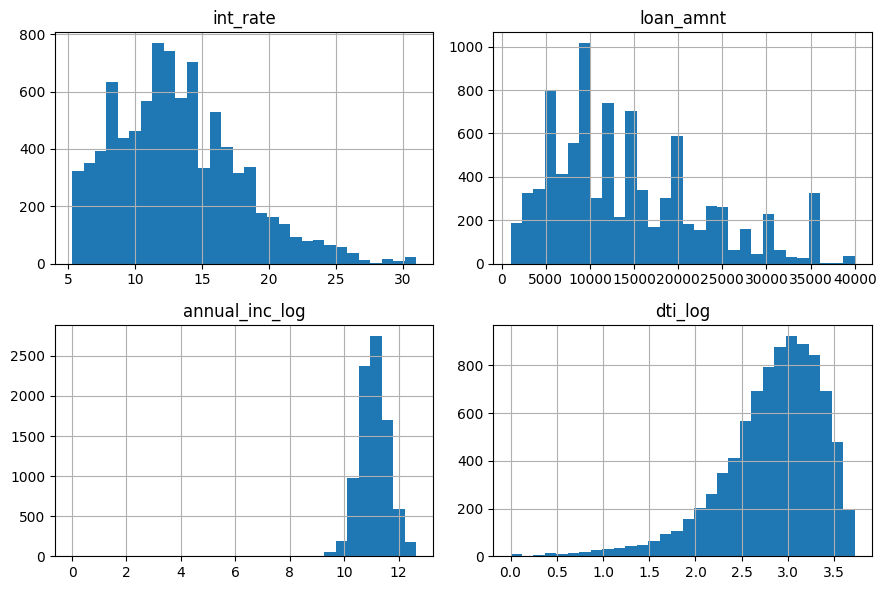

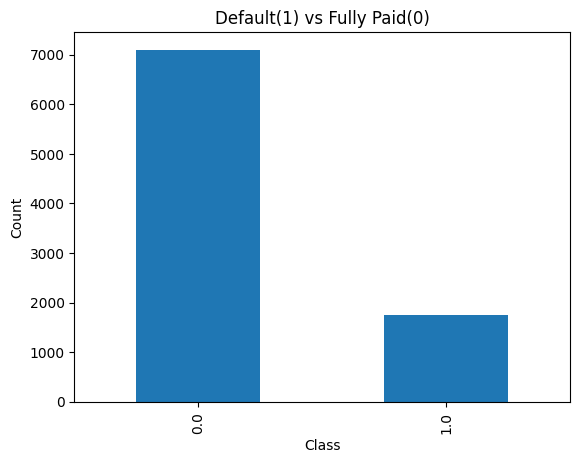

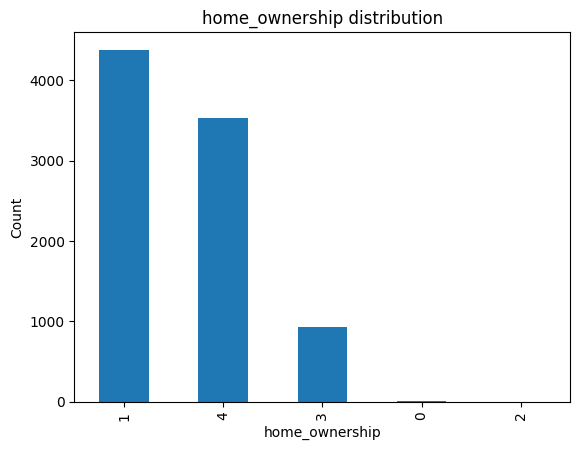

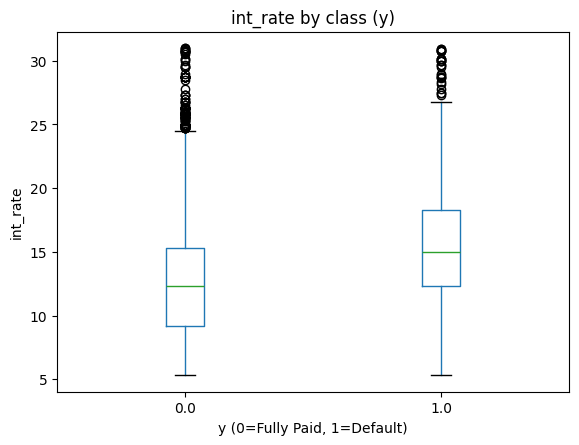

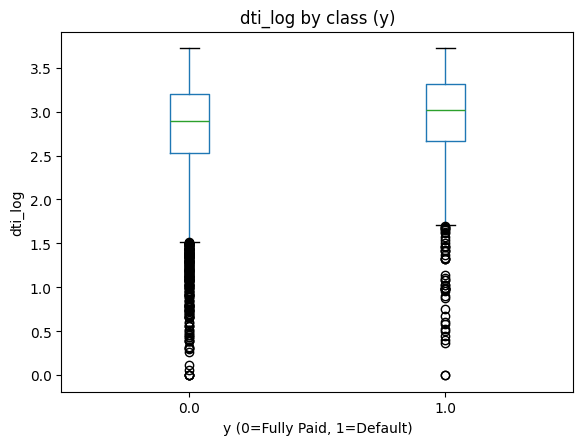

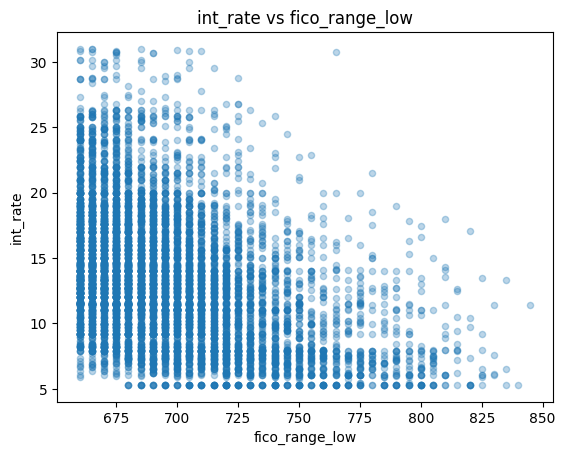

In [63]:
# REQUIRED PLOTS
viz = df_eda.copy()
if "annual_inc" in viz.columns:
    viz["annual_inc_cap"] = viz["annual_inc"].clip(upper=viz["annual_inc"].quantile(0.995))
    viz["annual_inc_log"] = np.log1p(viz["annual_inc_cap"])
if "dti" in viz.columns:
    viz["dti_cap"] = viz["dti"].clip(upper=viz["dti"].quantile(0.995))
    viz["dti_log"] = np.log1p(viz["dti_cap"])

# 1) Numeric histograms
num_show = [c for c in ["int_rate","loan_amnt","annual_inc_log","dti_log"] if c in viz.columns]
if num_show:
    viz[num_show].hist(bins=30, figsize=(9,6))
    plt.tight_layout(); plt.show()

# 2) Target bar
viz["y"].value_counts().sort_index().plot(kind="bar")
plt.title("Default(1) vs Fully Paid(0)"); plt.xlabel("Class"); plt.ylabel("Count"); plt.show()

# 3) Categorical bar
if "home_ownership" in df_eda.columns:
    ho = df_eda["home_ownership"].fillna("Missing")
    (ho.value_counts()
       .sort_values(ascending=False)
       .plot(kind="bar"))
    plt.title("home_ownership distribution"); plt.xlabel("home_ownership"); plt.ylabel("Count"); plt.show()

# 4) Box plots by class
for c in [col for col in ["int_rate","dti_log"] if col in viz.columns]:
    viz.boxplot(column=c, by="y", grid=False)
    plt.title(f"{c} by class (y)"); plt.suptitle("")
    plt.xlabel("y (0=Fully Paid, 1=Default)"); plt.ylabel(c)
    plt.show()

# 5) One relationship plot (scatter)
x, y_ = "fico_range_low", "int_rate"
if x in viz.columns and y_ in viz.columns:
    viz.plot(kind="scatter", x=x, y=y_, alpha=0.3)
    plt.title(f"{y_} vs {x}"); plt.show()

Correlation heatmap (BEFORE corr-drop)

Leakage columns dropped: ['last_fico_range_low', 'last_fico_range_high', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d']


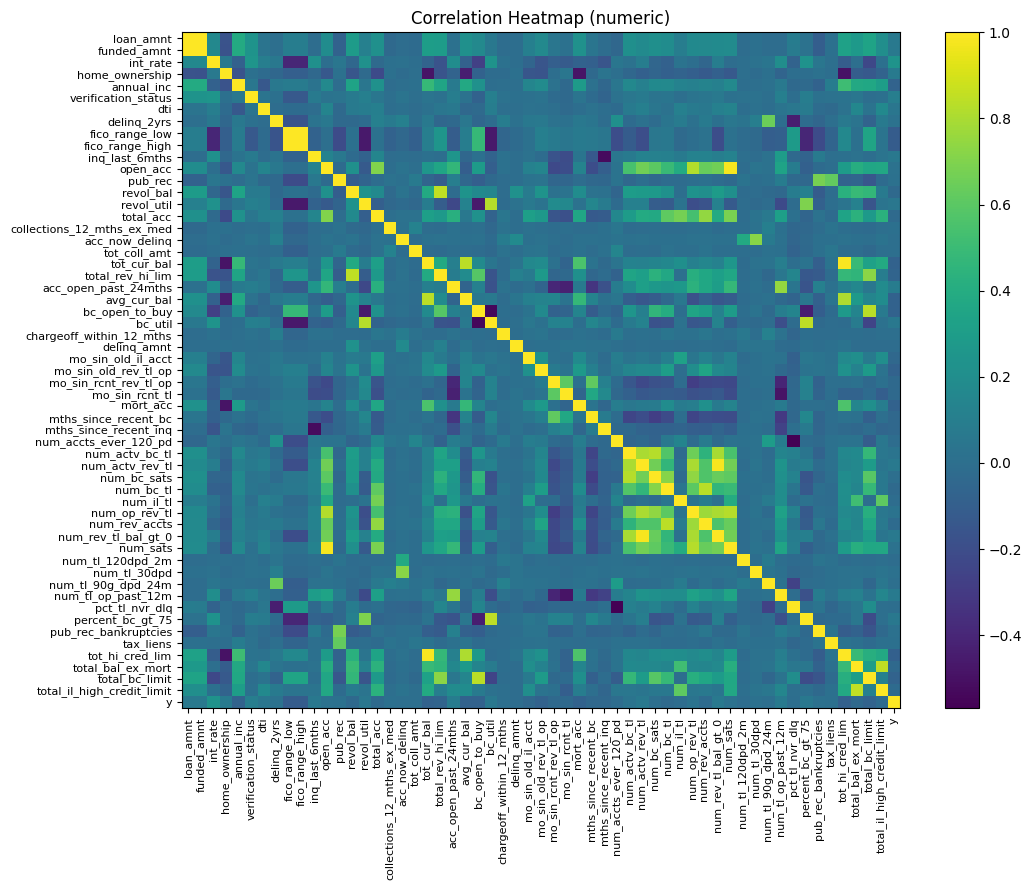

Top correlations with y:
 int_rate                0.236097
fico_range_low         -0.109925
fico_range_high        -0.109925
verification_status     0.101628
acc_open_past_24mths    0.088887
tot_hi_cred_lim        -0.087364
tot_cur_bal            -0.077994
mort_acc               -0.077625
avg_cur_bal            -0.077585
home_ownership          0.075592
mo_sin_old_rev_tl_op   -0.075292
bc_open_to_buy         -0.075140
Name: y, dtype: float64

Top feature–feature correlations:
 fico_range_low              fico_range_high        1.000000
loan_amnt                   funded_amnt            0.999422
tot_hi_cred_lim             tot_cur_bal            0.984451
open_acc                    num_sats               0.981463
num_actv_rev_tl             num_rev_tl_bal_gt_0    0.977703
total_il_high_credit_limit  total_bal_ex_mort      0.851140
revol_bal                   total_rev_hi_lim       0.847907
percent_bc_gt_75            bc_util                0.841069
bc_open_to_buy              total_bc_l

In [64]:
LEAKAGE = [
    "last_fico_range_low","last_fico_range_high",
    "recoveries","collection_recovery_fee",
    "total_pymnt","total_pymnt_inv","last_pymnt_amnt","last_pymnt_d","next_pymnt_d",
    "settlement_status","settlement_date","settlement_amount","settlement_percentage","settlement_term",
]

drop_now = [c for c in LEAKAGE if c in df.columns]
if drop_now:
    df = df.drop(columns=drop_now)
    if 'df_eda' in globals():
        df_eda = df_eda.drop(columns=[c for c in LEAKAGE if c in df_eda.columns])

print("Leakage columns dropped:", drop_now)

# CORRELATION HEATMAP (numeric, leakage removed; pre corr-drop)
num_for_corr = [c for c in df_eda.select_dtypes(include=[np.number]).columns if c != "y"] + ["y"]

corr = df_eda[num_for_corr].corr(numeric_only=True)

plt.figure(figsize=(11,9))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Correlation Heatmap (numeric)")
plt.xticks(range(len(corr)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr)), corr.index, fontsize=8)
plt.tight_layout(); plt.show()

# Top correlations with the target
corr_y = (corr["y"]
          .drop("y", errors="ignore")
          .sort_values(key=lambda s: s.abs(), ascending=False))
print("Top correlations with y:\n", corr_y.head(12))

# strongest feature–feature correlations
c_abs = corr.abs().where(~np.eye(len(corr), dtype=bool))
top_pairs = (c_abs.stack()
                 .sort_values(ascending=False)
                 .drop_duplicates())
print("\nTop feature–feature correlations:\n", top_pairs.head(12))

Preview feature selection (corr-drop + MI/Fisher)

In [65]:
# High correlation (numeric)
num_cols_corr = [c for c in df.select_dtypes(include=[np.number]).columns
                 if c not in (TARGET_COL, "y")]
drop_corr = []
if len(num_cols_corr) >= 2:
    corr = df[num_cols_corr].corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    for col in upper.columns:
        drop_corr += upper.index[upper[col] > CORR_THRESHOLD].tolist()
    drop_corr = sorted(set(drop_corr))
    df = df.drop(columns=drop_corr)

y_enc = df["y"].astype(int).values

# Separate X
X = df.drop(columns=[TARGET_COL, "y"])

# Split types
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

cat_imp = SimpleImputer(strategy="most_frequent")
num_imp = SimpleImputer(strategy="median")

X_cat = pd.DataFrame(index=X.index)
X_num = pd.DataFrame(index=X.index)

if cat_cols:
    X_cat = pd.DataFrame(cat_imp.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)
if num_cols:
    X_num = pd.DataFrame(num_imp.fit_transform(X[num_cols]), columns=num_cols, index=X.index)

# Drop ultra high-cardinality categoricals
ok_cats, drop_cats = [], []
for c in X_cat.columns:
    if pd.Series(X_cat[c]).nunique(dropna=True) <= MAX_CAT_CARD:
        ok_cats.append(c)
    else:
        drop_cats.append(c)
if drop_cats:
    X_cat = X_cat.drop(columns=drop_cats)

# 1) Mutual information
mi_scores = pd.Series(dtype=float)
if not X_cat.empty:
    mi_vals = {}
    for c in ok_cats:
        le_c = LabelEncoder()
        x_c = le_c.fit_transform(pd.Series(X_cat[c]).astype(str))
        mi = mutual_info_classif(x_c.reshape(-1,1), y_enc, random_state=RANDOM_SEED, discrete_features=True)
        mi_vals[c] = float(mi[0])
    mi_scores = pd.Series(mi_vals).sort_values(ascending=False)

# 2) Fisher Score
fisher_scores = fisher_scores_numeric(X_num, y_enc).sort_values(ascending=False)

keep_cats = keep_top(mi_scores, top_k=CAT_KEEP_TOP_K, top_pct=CAT_KEEP_TOP_PCT, positive_only=True)
keep_nums = keep_top(fisher_scores, top_k=NUM_KEEP_TOP_K, top_pct=NUM_KEEP_TOP_PCT, positive_only=False)

selected_cols = list(keep_cats) + list(keep_nums)
selected_cols = [c for c in selected_cols if c in X.columns]

df_selected = pd.concat([df[["y", TARGET_COL]], X[selected_cols]], axis=1)

print(f"Selected categorical (MI>0): {len(keep_cats)}")
print(f"Selected numeric (Fisher):   {len(keep_nums)}")
print(f"Total selected features:     {len(selected_cols)} | Final shape: {df_selected.shape}")


Selected categorical (MI>0): 8
Selected numeric (Fisher):   20
Total selected features:     28 | Final shape: (8848, 30)


Data preprocessing

In [66]:
# DATA PREPROCESSING
# Purpose: handle missing values, standardize numerics, and one-hot encode categoricals.

# 0) Inputs from previous cell
assert set(["y", TARGET_COL]).issubset(df_selected.columns), "df_selected must include y and loan_status"
y = df_selected["y"].astype(int).values
X = df_selected.drop(columns=["y", TARGET_COL]).copy()

num_cols_model = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_model = X.select_dtypes(include=["object","category"]).columns.tolist()
print(f"Preprocess on: {len(num_cols_model)} numeric, {len(cat_cols_model)} categorical columns")

# 1) Column-wise pipelines
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols_model),
        ("cat", cat_pipe, cat_cols_model),
    ],
    remainder="drop"
)

# 2) Fit+transform (Fit on TRAIN only)
X_model = preprocess.fit_transform(X)
print("X_model shape:", X_model.shape, "| y shape:", y.shape)

print("Preprocessing complete: numerics imputed+standardized, categoricals imputed+one-hot encoded.")

Preprocess on: 20 numeric, 8 categorical columns
X_model shape: (8848, 142) | y shape: (8848,)
Preprocessing complete: numerics imputed+standardized, categoricals imputed+one-hot encoded.


Save outputs

In [67]:
# Save
df_selected.to_csv(OUT_FILE, index=False)
print(f"Saved cleaned + feature-selected dataset → {OUT_FILE}")

# Summary
print("\n ------SUMMARY-----")
print(f"- Manual dropped: {len(drop_manual_present)}")
print(f"- All-NA dropped: {len(all_na_cols)}")
print(f"- Constant dropped: {len(const_cols)}")
print(f"- High-missing (> {MISS_DROP_PCT}%): {len(high_missing_cols)}")
print(f"- High-corr (> {CORR_THRESHOLD}): {len(drop_corr)}")
print(f"- High-cardinality cats dropped (> {MAX_CAT_CARD} unique): {len(drop_cats)}")
print(f"- MI-selected categorical: {len(keep_cats)} (of {len(ok_cats)})")
print(f"- Fisher-selected numeric: {len(keep_nums)} (of {len(num_cols)})")
gc.collect()

Saved cleaned + feature-selected dataset → Cleaned_columns_data.csv

 ------SUMMARY-----
- Manual dropped: 53
- All-NA dropped: 1
- Constant dropped: 1
- High-missing (> 30.0%): 22
- High-corr (> 0.95): 5
- High-cardinality cats dropped (> 60 unique): 5
- MI-selected categorical: 8 (of 8)
- Fisher-selected numeric: 20 (of 49)


55042

In [68]:
y = df_selected["y"].astype(int).values
X = df_selected.drop(columns=["y", TARGET_COL]).copy()

num_cols_final = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_final = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Features: {len(num_cols_final)} numerical, {len(cat_cols_final)} categorical")
print(f"Samples: {len(y)}, Class dist: {np.bincount(y)}")

# Unscaled version (for tree-based models)
num_pipe_unscaled = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_pipe_unscaled = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_unscaled = ColumnTransformer([
    ("num", num_pipe_unscaled, num_cols_final),
    ("cat", cat_pipe_unscaled, cat_cols_final)
], remainder="drop")

X_unscaled = preprocessor_unscaled.fit_transform(X)
feature_names = (num_cols_final + 
    preprocessor_unscaled.named_transformers_["cat"]["onehot"].get_feature_names_out(cat_cols_final).tolist())
X_unscaled_df = pd.DataFrame(X_unscaled, columns=feature_names)

# Scaled version (for distance-based models)
num_pipe_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_scaled = ColumnTransformer([
    ("num", num_pipe_scaled, num_cols_final),
    ("cat", cat_pipe_scaled, cat_cols_final)
], remainder="drop")

X_scaled = preprocessor_scaled.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# Save files
X_unscaled_df.to_csv("X_unscaled.csv", index=False)
pd.DataFrame(y, columns=["y"]).to_csv("y.csv", index=False)

Features: 20 numerical, 8 categorical
Samples: 8848, Class dist: [7100 1748]


In [69]:
# Dimensionality reduction for high-dimensional data
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=RANDOM_SEED)
X_scaled_pca = pca.fit_transform(X_scaled_df)

print(f"Original features: {X_scaled_df.shape[1]}")
print(f"PCA components: {X_scaled_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.1%}")

pca_cols = [f"PC{i+1}" for i in range(X_scaled_pca.shape[1])]
pd.DataFrame(X_scaled_pca, columns=pca_cols).to_csv("X_scaled_pca.csv", index=False)


Original features: 142
PCA components: 20
Variance explained: 84.9%


EDA insights & challenges.


*   Sample & reproducibility: We did EDA on a 15k random sample (seed=42), so results are repeatable.
*   Class imbalance: About 80% Fully Paid vs 20% Charged Off. We’ll try class weights, and only consider SMOTE on the TRAIN split if needed.
*   Leakage removed: We dropped columns that reveal the outcome (e.g., payments, recoveries, last FICO, settlements/hardship).
*   Key signals: After removing leakage, higher interest rate and lower FICO are associated with default.
*   Correlations: Some features are very similar (e.g., FICO high/low, loan_amnt vs funded_amnt). We drop one of each pair when |r| > 0.95.
*   Skewed features: Income and DTI are right-skewed. We show capped/log plots for readability; modeling will standardize features in a pipeline.
*   Missing values: many hardship/settlement fields are almost entirely missing and were removed; remaining NAs are imputed (median for numeric, most-frequent for categorical), with scaling and one-hot encoding.